In [9]:
import data_transformers as dt
from model_wrapper import model_wrapper as mw
import constants as co
from auxiliary import loggers, plotScatterWithIdeal, create_precision_recall_plot

from pathlib import Path
import sys

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, accuracy_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, roc_auc_score, recall_score, \
precision_score, accuracy_score, precision_recall_curve
from sklearn.feature_selection import VarianceThreshold

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.decomposition import PCA

from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import BayesianRidge, LinearRegression, LogisticRegression, RidgeClassifier, RidgeClassifierCV

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from functools import partial

import pickle
import json

from IPython.display import IFrame

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
random_seed = 42

%config Completer.use_jedi = False

In [3]:
l = loggers.get_logger(logger_name="logger")

In [4]:
def set_up_mlflow(experiment):
    server_ip = "10.210.200.190"
    os.environ['AWS_ACCESS_KEY_ID'] = 'mlflow'
    os.environ['AWS_SECRET_ACCESS_KEY'] = 'uSPmPqTZv4YQh8M7oMqq'
    os.environ['MLFLOW_S3_ENDPOINT_URL'] = f"http://{server_ip}:9000"
    mlflow.set_tracking_uri(f"http://{server_ip}:9002")
    mlflow.set_experiment(experiment)

In [5]:
l.info(os.environ['CONDA_DEFAULT_ENV'])

2022-06-29 08:11:44,447 - logger - INFO - rorgammaqsar
2022-06-29 08:11:44,447 - logger - INFO - rorgammaqsar


# Data load

In [6]:
smiles_column = "canonical_smiles_get_levels"
target_column = "IC50_nM"

max_level_activity = 13
train_data = pd.read_csv((co.DATA_DIR/"ror_gamma_homo_sapiens.csv").absolute().as_posix())
activity_columns = ["act_"+str(iii) for iii in range(max_level_activity)]
train_data["target_std"] = train_data[activity_columns].apply(lambda x: np.std(x), axis=1)
train_data["target_min"] = train_data[activity_columns].apply(lambda x: np.min(x), axis=1)
train_data["target_max"] = train_data[activity_columns].apply(lambda x: np.max(x), axis=1)
train_data["target_mean"] = train_data[activity_columns].apply(lambda x: np.mean(x), axis=1)
train_data["target_median"] = train_data[activity_columns].apply(lambda x: np.median(x[~np.isnan(x)]), axis=1)
train_data[target_column] = train_data["target_median"]
# here we exclude the molecules for which the std of the available measurements is significant 
target_std_threshold = 100
train_data = train_data[train_data["target_std"] < target_std_threshold]
train_data

,molregno,standard_value_get_mean,standard_units_get_levels,standard_type_get_levels,chembl_id_compound_get_levels,canonical_smiles_get_levels,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9,act_10,act_11,act_12,target_std,target_min,target_max,target_mean,target_median,IC50_nM
0,2208,199.53,nM,IC50,CHEMBL38,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1,199.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,199.53,199.53,199.53,199.53,199.53
1,40459,31900.00,nM,IC50,CHEMBL28721,O=C(O)C(S)C(S)C(=O)O,31900.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,31900.00,31900.00,31900.00,31900.00,31900.00
3,155592,10000.00,nM,IC50,CHEMBL418971,CC(C)(c1ccc(O)cc1)c1ccc(O)cc1,10000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10000.00,10000.00,10000.00,10000.00,10000.00
5,242555,80000.00,nM,IC50,CHEMBL358290,NS(=O)(=O)c1ccc(N/C(S)=N\CCc2ccccc2)cc1,80000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,80000.00,80000.00,80000.00,80000.00,80000.00
6,342149,10000.00,nM,IC50,CHEMBL382792,O=S(=O)(Nc1ccc(C(O)(C(F)(F)F)C(F)(F)F)cc1)c1cc...,10000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10000.00,10000.00,10000.00,10000.00,10000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2214,2459056,193.60,nM,IC50,CHEMBL4588625,C[C@H]1CN(C2CCc3ccc(NC(=O)c4cccc(C#N)c4)cc32)C...,193.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,193.60,193.60,193.60,193.60,193.60
2215,2459160,75.00,nM,IC50,CHEMBL4588729,O=C(O)c1ccc(-n2cc(C(=O)c3c(Cl)cccc3Cl)c3ccccc3...,75.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,75.00,75.00,75.00,75.00,75.00
2217,2462878,27.00,nM,IC50,CHEMBL4592447,Cc1cccc(Cl)c1C(=O)c1cn(-c2ccc(C(=O)O)cc2F)c2nc...,27.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,27.00,27.00,27.00,27.00,27.00
2218,2463217,357.70,nM,IC50,CHEMBL4592786,N#Cc1cccc(NC(=O)Nc2ccc3c(c2)C(N2CC4CCC(C2)N4C(...,357.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,357.70,357.70,357.70,357.70,357.70


# Data

In [8]:
smiles_codes = train_data["canonical_smiles_get_levels"].copy()
target = train_data["IC50_nM"].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_file = "pipeline_configuration_all_descriptors.json"
pipeline_configuration = dt.read_in_pipeline(pipeline_file=pipeline_file, pipeline_directory=co.PIPELINE_DIR)
pipeline = dt.create_pipeline(pipeline_configuration=pipeline_configuration["feature_transform"])

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

pipeline.fit(X=smiles_codes, y=None)
X_train = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes)
X_train = dt.process_molecular_features(pipeline=pipeline, X=X_train)

2022-06-29 08:14:29,167 - logger - INFO - CreateFPS fit...
2022-06-29 08:14:29,167 - logger - INFO - CreateFPS fit...
2022-06-29 08:14:29,168 - logger - INFO - CreateFPS fit...
2022-06-29 08:14:29,168 - logger - INFO - CreateFPS fit...
2022-06-29 08:14:29,169 - logger - INFO - CreateFPS transform...
2022-06-29 08:14:29,169 - logger - INFO - CreateFPS transform...
100%|██████████| 2039/2039 [12:17<00:00,  2.77it/s]


In [10]:
mmscaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(data=mmscaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

<AxesSubplot:>

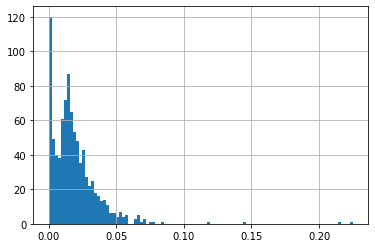

In [12]:
variance = X_train_scaled.apply(lambda x: np.var(x), axis=0)
variance.hist(bins=100)

In [13]:
high_variance_features = variance[variance > 0.05].sort_values(ascending=False)
descriptor_groups = dt.get_mordred_feature_names()[0]

In [15]:
def get_group_descriptor(descriptor: str, groups: dict) -> str:
    for key, item in groups.items():
        if descriptor in item: return key 

In [21]:
hv_groups = []
top_n = 10
for iii in range(top_n):
    this_group = get_group_descriptor(high_variance_features.index[iii], descriptor_groups)
    hv_groups.append(this_group)
    print(high_variance_features.index[iii], high_variance_features[iii], this_group)
print(list(set(hv_groups)))

Lipinski 0.22498358998066403 Lipinski
GhoseFilter 0.21406939375651984 Lipinski
SRW09 0.1444486974505348 WalkCount
SRW07 0.11770829826806475 WalkCount
nF 0.0852268729102965 AtomCount
nX 0.07716858195063837 AtomCount
VSA_EState1 0.07504871008819229 MoeType
Xc-4d 0.07164704282466451 Chi
PEOE_VSA4 0.07067923574384685 MoeType
SRW05 0.0705073464611429 WalkCount
['Lipinski', 'Chi', 'WalkCount', 'AtomCount', 'MoeType']


array([[<AxesSubplot:title={'center':'SLogP'}>,
        <AxesSubplot:title={'center':'SMR'}>],
       [<AxesSubplot:title={'center':'naRing'}>,
        <AxesSubplot:title={'center':'nHBAcc'}>]], dtype=object)

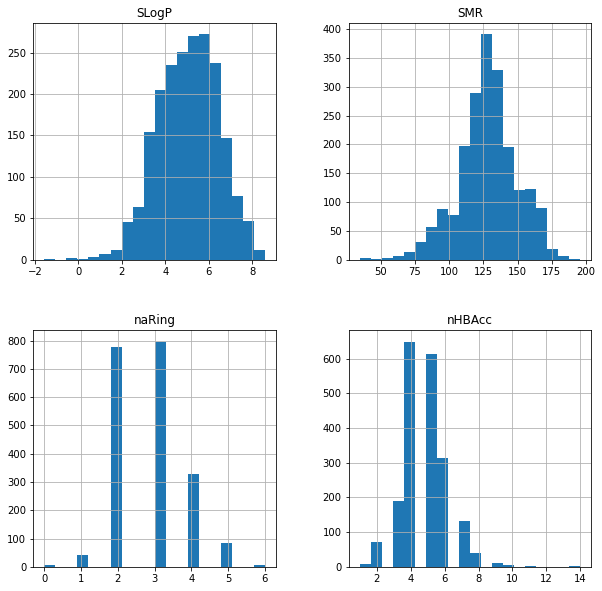

In [8]:
MDs = ["SLogP", "SMR", "naRing", "nHBAcc", "nHBDon", "nRot", "MW", "TopoPSA", "QED"]
X_train[MDs[:4]].hist(bins=20, grid=True, figsize=(10, 10))

array([[<AxesSubplot:title={'center':'nHBDon'}>,
        <AxesSubplot:title={'center':'nRot'}>],
       [<AxesSubplot:title={'center':'MW'}>,
        <AxesSubplot:title={'center':'TopoPSA'}>]], dtype=object)

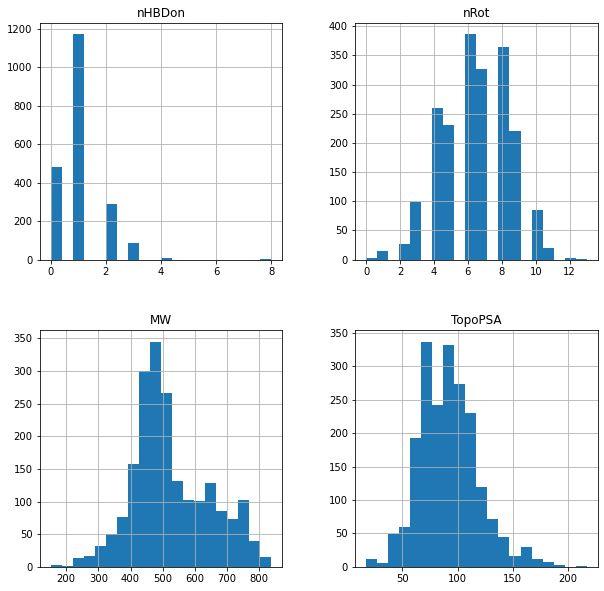

In [9]:
X_train[MDs[4:8]].hist(bins=20, grid=True, figsize=(10, 10))

array([[<AxesSubplot:title={'center':'QED'}>]], dtype=object)

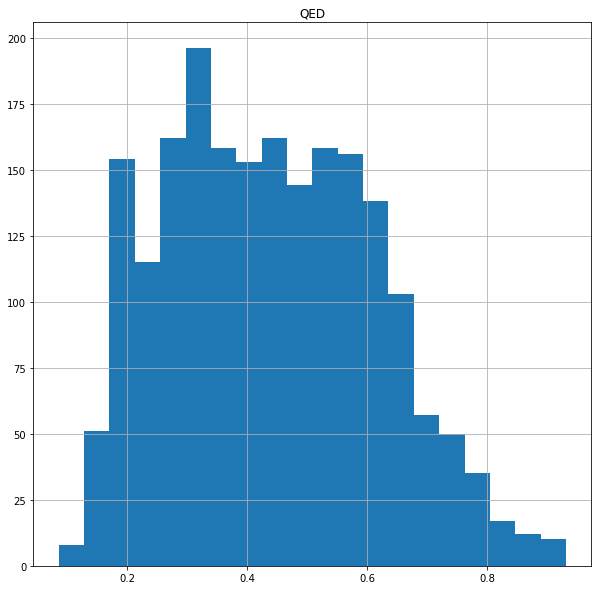

In [10]:
X_train[[MDs[-1]]].hist(bins=20, grid=True, figsize=(10, 10))

In [11]:
def create_histograms(df, label, directory="plots", return_plot=True):
    feature_list = df.columns
    n_columns = 5
    n_rows = int(np.ceil(len(feature_list) / n_columns))
    
    n_rows_to_size = int(3.2 * n_rows)
    fig = plt.figure(figsize=(15, n_rows_to_size))
    
    for idx, feature in enumerate(feature_list):
        plt.subplot(n_rows, n_columns, idx+1)
        f = plt.gca()
        f.axes.get_yaxis().set_visible(False)
        f.set_title(feature)

        plt.hist(df[feature], color='#3F5D7D', bins=25)
        plt.grid(True)
    fig.suptitle('Set of molecular descriptors, batch: '+str(label), fontsize=16, y=1.00)
    plt.tight_layout()
    fig.patch.set_facecolor('white')
    path = Path(directory)
    file_name = 'molecular_descriptors_histogram_'+str(label)+'.png'
    if os.path.isdir(directory): 
        plt.savefig((path/file_name).as_posix())
    else:
        l.error("The directory for plot storage does not exist")
    if return_plot: 
        return fig
    else:
        plt.close(fig)
        

In [12]:
from mordred import ABCIndex, AcidBase, AdjacencyMatrix, Aromatic, AtomCount, Autocorrelation, BCUT, BalabanJ, BaryszMatrix, \
    BertzCT, BondCount, CPSA, CarbonTypes, Chi, Constitutional, DetourMatrix, DistanceMatrix, EccentricConnectivityIndex, \
        ExtendedTopochemicalAtom, FragmentComplexity, Framework, GeometricalIndex, GravitationalIndex, HydrogenBond, \
        InformationContent, KappaShapeIndex, Lipinski, LogS, McGowanVolume, MoRSE, MoeType, MolecularDistanceEdge, MolecularId, \
        MomentOfInertia, PBF, PathCount, Polarizability, RingCount, RotatableBond, SLogP, TopoPSA, TopologicalCharge, TopologicalIndex, \
        VdwVolumeABC, VertexAdjacencyInformation, WalkCount, Weight, WienerIndex, ZagrebIndex

In [13]:
descriptor_classes_str = ["ABCIndex", "AcidBase", "AdjacencyMatrix", "Aromatic", "AtomCount", "Autocorrelation", "BCUT", "BalabanJ", 
                      "BaryszMatrix", "BertzCT", "BondCount", "CPSA", "CarbonTypes", "Chi", "Constitutional", "DetourMatrix", 
                      "DistanceMatrix", "EccentricConnectivityIndex", "ExtendedTopochemicalAtom", "FragmentComplexity", 
                      "Framework", "GeometricalIndex", "GravitationalIndex", "HydrogenBond", "InformationContent", "KappaShapeIndex", 
                      "Lipinski", "LogS", "McGowanVolume", "MoRSE", "MoeType", "MolecularDistanceEdge", "MolecularId", "MomentOfInertia", "PBF", 
                      "PathCount", "Polarizability", "RingCount", "RotatableBond", "SLogP", "TopoPSA", "TopologicalCharge", "TopologicalIndex", 
                      "VdwVolumeABC", "VertexAdjacencyInformation", "WalkCount", "Weight", "WienerIndex", "ZagrebIndex"]

In [15]:
descriptor_classes = [ABCIndex, AcidBase, AdjacencyMatrix, Aromatic, AtomCount, Autocorrelation, BCUT, BalabanJ, 
                      BaryszMatrix, BertzCT, BondCount, CPSA, CarbonTypes, Chi, Constitutional, DetourMatrix, 
                      DistanceMatrix, EccentricConnectivityIndex, ExtendedTopochemicalAtom, FragmentComplexity, 
                      Framework, GeometricalIndex, GravitationalIndex, HydrogenBond, InformationContent, KappaShapeIndex, Lipinski, 
                      LogS, McGowanVolume, MoRSE, MoeType, MolecularDistanceEdge, MolecularId, MomentOfInertia, PBF, PathCount, 
                      Polarizability, RingCount, RotatableBond, SLogP, TopoPSA, TopologicalCharge, TopologicalIndex, 
                      VdwVolumeABC, VertexAdjacencyInformation, WalkCount, Weight, WienerIndex, ZagrebIndex]

In [16]:
from mordred import Calculator
desc_feature_names = {}
desc_data = {}

In [17]:
for item1, item2 in zip(descriptor_classes_str, descriptor_classes):
    to_be_calculated = [item2]
    calc = Calculator(to_be_calculated, ignore_3D=True)
    mol_objs = [Chem.MolFromSmiles(item) for item in smiles_codes.to_list()]
    molecular_descriptors = calc.pandas(mol_objs)
    desc_data[item1] = molecular_descriptors
    desc_feature_names[item1] = molecular_descriptors.columns.to_list()
    #print(molecular_descriptors.columns.to_list())

100%|██████████| 2039/2039 [00:02<00:00, 989.12it/s] 


In [36]:
a = {"a": "A"}
b = {"b": "B"}
a.update(b)

In [37]:
a

{'a': 'A', 'b': 'B'}

In [28]:
import mordred
mordred.__version__
mordred_version = mordred.__version__

In [27]:
desc_total = 0
for key, value in desc_feature_names.items():
    desc_total += len(value)
    print(key, len(value))
print("Total number of descriptors: "+str(desc_total))

ABCIndex 2
AcidBase 2
AdjacencyMatrix 12
Aromatic 2
AtomCount 17
Autocorrelation 606
BCUT 24
BalabanJ 1
BaryszMatrix 104
BertzCT 1
BondCount 9
CPSA 2
CarbonTypes 11
Chi 56
Constitutional 16
DetourMatrix 14
DistanceMatrix 12
EccentricConnectivityIndex 1
ExtendedTopochemicalAtom 45
FragmentComplexity 1
Framework 1
GeometricalIndex 0
GravitationalIndex 0
HydrogenBond 2
InformationContent 42
KappaShapeIndex 3
Lipinski 2
LogS 1
McGowanVolume 1
MoRSE 0
MoeType 53
MolecularDistanceEdge 19
MolecularId 12
MomentOfInertia 0
PBF 0
PathCount 21
Polarizability 2
RingCount 138
RotatableBond 2
SLogP 2
TopoPSA 2
TopologicalCharge 21
TopologicalIndex 4
VdwVolumeABC 1
VertexAdjacencyInformation 1
WalkCount 21
Weight 2
WienerIndex 2
ZagrebIndex 4
Total number of descriptors: 1297


In [40]:
MOLECULAR_DESCRIPTORS_PARAMETERIZATION_FILE = "molecular_descriptors_feature_names"+"_"+mordred_version+".json"
with open(MOLECULAR_DESCRIPTORS_PARAMETERIZATION_FILE, "w") as f:
    json.dump(desc_feature_names, f)

ABCIndex
AcidBase
AdjacencyMatrix
Aromatic
AtomCount
Autocorrelation
BCUT
BalabanJ
BaryszMatrix
BertzCT
BondCount
CPSA
CarbonTypes
Chi
Constitutional
DetourMatrix
DistanceMatrix
EState


/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6607: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6608: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


EccentricConnectivityIndex
ExtendedTopochemicalAtom
FragmentComplexity
Framework
GeometricalIndex
GravitationalIndex
HydrogenBond
InformationContent
KappaShapeIndex
Lipinski
LogS


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


McGowanVolume
MoRSE
MoeType
MolecularDistanceEdge
MolecularId
MomentOfInertia
PBF
PathCount
Polarizability
RingCount
RotatableBond
SLogP
TopoPSA
TopologicalCharge
TopologicalIndex
VdwVolumeABC
VertexAdjacencyInformation
WalkCount
Weight
WienerIndex
ZagrebIndex


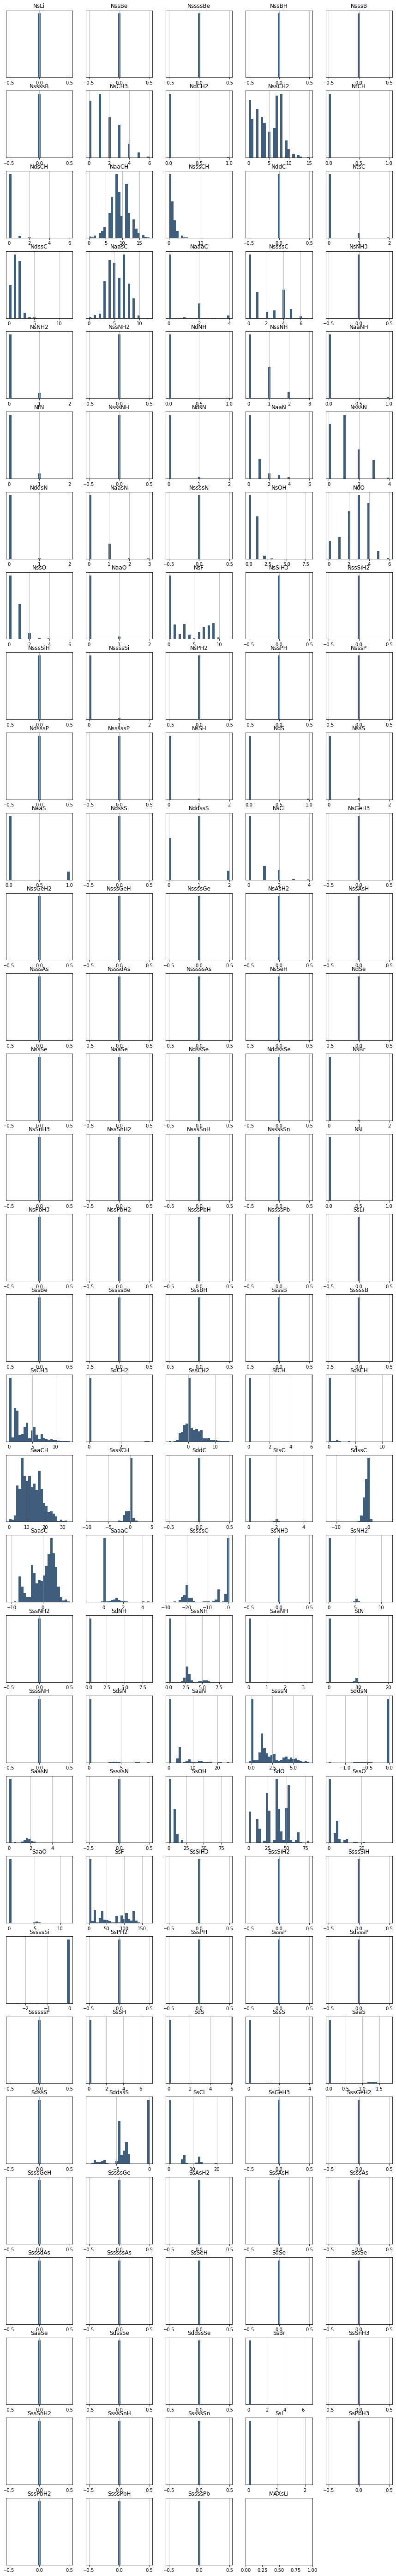

<Figure size 1080x0 with 0 Axes>

<Figure size 1080x0 with 0 Axes>

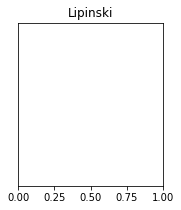

<Figure size 1080x0 with 0 Axes>

<Figure size 1080x0 with 0 Axes>

<Figure size 1080x0 with 0 Axes>

In [27]:
show_plots = False
for item in descriptor_classes_str:
    plot_data = desc_data[item].copy()
    for feature in plot_data.columns.to_list():
        if plot_data[feature].dtypes == object: plot_data[feature] = plot_data[feature].astype(float)
        if plot_data[feature].std() < 10E-10: plot_data.drop(feature, axis=1)
    print(item)
    try:
        fig = create_histograms(plot_data, item, return_plot=False)
    except:
        pass